# Assessment test: Data Engineering, Enrico Grandi 
- This test is intended to verify basic skills in Data Engineering (data extraction, modeling, critical reasoning) for candidates to the role of Data Engineer in ShopFully. 

- The deadline for returning the output is specified to the candidate when sharing the test. The results will then be used as a topic for discussion in the subsequent interview. 

- The candidate is left free to decide the preferred tools with which to carry out the test, it is sufficient that all the results and the coding are then shared through a text document for further discussion. 

## Project description 
- For the ShopFully team it is very important to understand the weather conditions for certain locations. 

- Use the OpenWeatherMap API (use a free tier subscription) to get the current weather conditions for 3 cities where ShopFully has offices: Milano, Bologna, Cagliari. 

- The task has two main parts, one focuses on the modeling while the other one is centered on script writing. 



## Part 1 - data modeling

### 1. Look at the data structure provided by the API documentation.

I will use `/onecall/timemachine` endpoint in order to download historical and current data. The answer is a json with these fields:



<code>https://api.openweathermap.org/data/3.0/onecall/timemachine?lat={lat}&lon={lon}&dt={time}&appid={API key}</code>


**Parameters to get data**

| Parameter | Required/Optional | Description |
|---|---|---|
| `lat` | required | Latitude, decimal (-90; 90). If you need the geocoder to automatic convert city names and zip-codes to geo coordinates and the other way around. |
| `lon` | required | Longitude, decimal (-180; 180). If you need the geocoder to automatic convert city names and zip-codes to geo coordinates and the other way around. |
| `dt` | required | Timestamp (Unix time, UTC time zone), e.g. dt=1586468027. Data is available **from January 1st, 1979 till 4 days ahead** |
| `appid` | required | Your unique API key (you can always find it on your account page under the ["API key" tab](https://home.openweathermap.org/api_keys)) |
| `units` | optional | Units of measurement. `standard`, `metric` and `imperial` units are available. If you do not use the `units` parameter, `standard` units will be applied by default. |
| `lang` | optional | You can use the `lang` parameter to get the output in your language. |


**Parameters json answer data**

- `lat` Latitude of the location, decimal (−90; 90)
- `lon` Longitude of the location, decimal (-180; 180)
- `timezone` Timezone name for the requested location
- `timezone_offset`  Shift in seconds from UTC
- `data`
  - `data.dt` Requested time, Unix, UTC
  - `data.sunrise` Sunrise time, Unix, UTC. For polar areas in midnight sun and polar night periods this parameter is not returned in the response
  - `data.sunset` Sunset time, Unix, UTC. For polar areas in midnight sun and polar night periods this parameter is not returned in the response
  - `data.temp` Temperature. Units – default: kelvin, metric: Celsius, imperial: Fahrenheit.
  - `data.feels_like` Temperature. This accounts for the human perception of weather. Units – default: kelvin, metric: Celsius, imperial: Fahrenheit.
  - `data.pressure` Atmospheric pressure on the sea level, hPa
  - `data.humidity` Humidity, %
  - `data.dew_point` Atmospheric temperature (varying according to pressure and humidity) below which water droplets begin to condense and dew can form. Units – default: kelvin, metric: Celsius, imperial: Fahrenheit.
  - `data.clouds` Cloudiness, %
  - `data.uvi` UV index
  - `data.visibility` Average visibility, metres. The maximum value of the visibility is 10 km
  - `data.wind_speed` Wind speed. Units – default: metre/sec, metric: metre/sec, imperial: miles/hour.
  - `data.wind_gust` (where available) Wind gust. Wind speed. Units – default: metre/sec, metric: metre/sec, imperial: miles/hour.
  - `data.wind_deg` Wind direction, degrees (meteorological)
  - `data.weather`
    - `data.weather.id` Weather condition id
    - `data.weather.main` Group of weather parameters (Rain, Snow, etc.)
    - `data.weather.description` Weather condition within the group
    - `data.weather.icon` Weather icon id
  - `data.rain` (where available)
    - `1h` Precipitation, mm/h. Only mm/h as units of measurement are available for this parameter
  - `data.snow` (where available)
    - `1h` Precipitation, mm/h. Only mm/h as units of measurement are available for this parameter



### 2. Decide which data could be considered important and bring value and discard the data which looks less relevant.

I will define importan and less relevant fields based on the questions.

#### **Important Fields**:

- **lat and lon**: Vital for pinpointing the location.
- **timezone**: Useful for correlating local time with UTC and understanding the data in a local context.
- **data.dt**: Essential for a timestamp on each data entry.
- **data.temp**: Critical for analyzing temperature.
- **data.weather.description**: Necessary for determining weather conditions.
- **data.wind_speed**: Critical for wind analysis.

#### **Less Relevant Fields**:

- **data.sunrise and data.sunset**: While interesting, they're not critical for the analysis.
- **data.weather**: Redundant.
- **timezone_offset**: Redundant.
- **data.pressure**: Atmospheric pressure is less relevant for the specific questions asked.
- **data.humidity**: Useful for a detailed weather analysis, but not critical for the proposed queries.
- **data.dew_point**: Useful for a detailed weather analysis, but not critical for the proposed queries.
- **data.clouds**: Useful for a detailed weather analysis, but not critical for the proposed queries.
- **data.uvi**: Useful for a detailed weather analysis, but not critical for the proposed queries.
- **data.visibility**: Useful for a detailed weather analysis, but not critical for the proposed queries.
- **data.wind_gust, data.wind_deg**: Only wind speed might be relevant based on the queries.
- **data.weather.id, data.weather.icon**: Not essential for data analysis.


### 3. The data granularity should be 1-hour (we want to have hourly temperature to be able to analyze historical data in the future). 


- Create a logical and physical model for this data having the following questions in mind: 
    - How many distinct weather conditions were observed (rain/snow/clear/…) in a certain period? 
    - Rank the most common weather conditions in a certain period of time per city? 
    - What are the temperature averages observed in a certain period per city? 
    - What city had the highest absolute temperature in a certain period of time?

- To have a separate table for city details and weather details. It reduces redundancy and allows easy scalability.
- For weather data, only the important fields are selected based on the questions provided.

##### Logical Schema:

- City:
    - city_id (Primary Key, Auto Increment)
    - city UNIQUE (Name of the city)
    - lat
    - lon
    - timezone

- WeatherHourly:
    - weather_id (Primary Key, Auto Increment)
    - city_id (Foreign Key to City)
    - timestamp (data.dt)
    - temperature (data.temp)
    - weather_description (data.weather.description)
    - wind_speed (data.wind_speed)



##### Phisycal Model:

```sql
CREATE TABLE City (
    city_id INT PRIMARY KEY AUTO_INCREMENT,
    city TEXT UNIQUE,
    lat DECIMAL(9,6),
    lon DECIMAL(9,6),
    timezone VARCHAR(50),
);

CREATE TABLE WeatherHourly (
    weather_id INT PRIMARY KEY AUTO_INCREMENT,
    city_id INT,
    dt BIGINT,
    temp DECIMAL(5,2),
    weather_description VARCHAR(100),
    wind_speed DECIMAL(5,2),
    FOREIGN KEY (city_id) REFERENCES City(city_id)
);
```

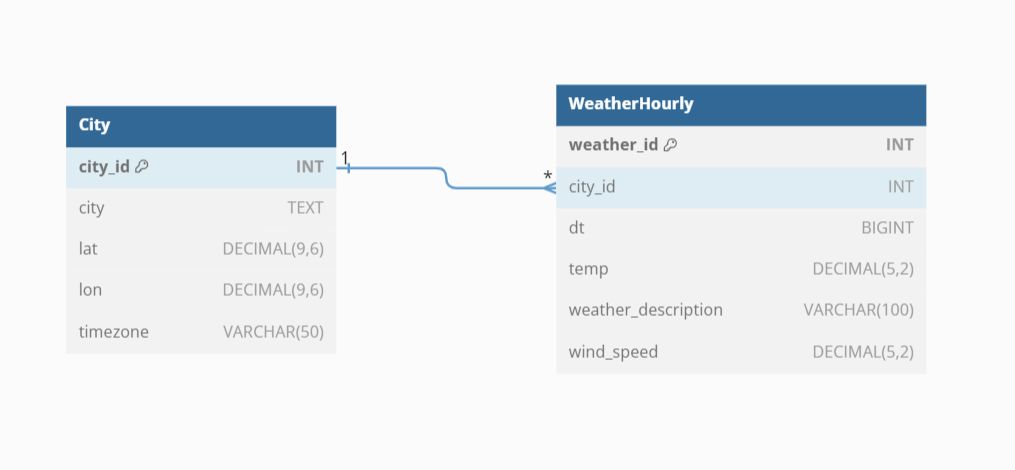


### 1. Count of distinct weather conditions in a period:




```sql 
-- Determine the number of distinct weather conditions for each city over the past 5 days.
-- Selecting the name of the city
-- Count the unique occurrences of each weather description for each city
-- Select from the Cities table
-- Join the Cities table with the WeatherHourly table based on city_id
-- Filter records from the WeatherHourly table to consider only the past 5 days
-- Group the results by city name to get separate counts for each city

SELECT 
    COUNT(DISTINCT weather_description) AS distinct_conditions 
FROM 
    WeatherHourly 
WHERE 
    datetime(dt, 'unixepoch') BETWEEN datetime('now', '-5 days') AND datetime('now') 

```

**Results**

14

### 2. Rank most common weather conditions in a period per city:


```sql
-- The SQL query aims to determine the most frequently occurring weather condition (description) for each city over the past 5 days.
-- Calculate the count of each weather condition for each city
-- Count occurrences of each weather description for each city
-- Join Cities table with WeatherHourly table based on city_id
-- Filter records for the past 5 days
-- Rank the weather conditions for each city based on their frequency, with the most frequent condition ranked 1
-- Rank each description for each city based on frequency
-- Select the top ranked weather condition for each city

WITH ConditionCounts AS (
    SELECT
        c.city,
        w.weather_description,
        COUNT(w.weather_description) AS count_desc  
    FROM Cities c
    JOIN WeatherHourly w ON c.city_id = w.city_id  
    WHERE datetime(w.dt, 'unixepoch') BETWEEN datetime('now', '-5 days') AND datetime('now') 
    GROUP BY c.city, w.weather_description
),
RankedConditions AS (
    SELECT 
        city,
        weather_description,
        count_desc,
        ROW_NUMBER() OVER (PARTITION BY city ORDER BY count_desc DESC) AS rnk  
    FROM ConditionCounts
)
SELECT city, weather_description, count_desc
FROM RankedConditions
WHERE rnk = 1;

```

**Results**

[('Bologna', 'clear sky', 45),
 ('Cagliari', 'clear sky', 44),
 ('Milan', 'scattered clouds', 33),
 ('Vicenza', 'overcast clouds', 46)]


### 3. Average temperature in a period per city:

```sql
-- This SQL query aims to calculate the average temperature for each city over the past 5 days.
-- For each city, calculate its average temperature
-- Calculate the average temperature for each city
-- Join the Cities table with the WeatherHourly table based on the city_id
-- Filter the records to include only those from the past 5 days
-- Group the results by city to compute the average temperature for each city

SELECT c.city, 
       AVG(w.temp) AS avg_temp 
FROM Cities c
JOIN WeatherHourly w ON c.city_id = w.city_id  
WHERE datetime(w.dt, 'unixepoch') BETWEEN datetime('now', '-5 days') AND datetime('now') 
GROUP BY c.city; 

```

**Results**

[('Bologna', 16.75092783505154),
 ('Cagliari', 22.274948453608257),
 ('Milan', 15.159278350515459),
 ('Vicenza', 16.113124999999997)]

### 4. City with the highest absolute temperature in a period:


```sql
-- 'MaxTemps' is created to compute the highest absolute temperature for each city
-- For each city, calculate the maximum absolute temperature value 
-- Filter the records to include only those from the past 5 days
-- Group the results by city to compute the maximum absolute temperature for each city
-- The main query identifies the city with the highest temperature from the CTE
-- Order the results in descending order of absolute temperature to have the city with the highest value at the top
-- Limit the results to show only the top city


WITH MaxTemps AS (
    SELECT
        c.city,
        MAX((w.temp)) AS max_temp
    FROM Cities c
    JOIN WeatherHourly w ON c.city_id = w.city_id
    WHERE datetime(w.dt, 'unixepoch') BETWEEN datetime('now', '-5 days') AND datetime('now')
    GROUP BY c.city
)

SELECT city, max_abs_temp
FROM MaxTemps
ORDER BY max_temp DESC
LIMIT 1;

```

**Results** 

[('Cagliari', 29.8)]

### 5. City with the highest daily temperature variation in a period:


```sql 
-- 'DailyVariation' is created to compute daily temperature variations for each city
-- For each city and day, calculate the temperature variation by subtracting the minimum daily temperature from the maximum daily temperature
-- Convert the epoch timestamp in 'dt' column to a date format and group the records by this date
-- Filter the records to include only those from the past 5 days
-- Group the results by city and day to compute the temperature variation for each city on each day
-- With the daily variations calculated in the CTE, the main query identifies the city with the largest single-day temperature variation
-- Group the results by city to consider the maximum temperature variation for each city
-- Order the results in descending order of temperature variation to have the city with the largest variation at the top
-- Limit the results to show only the top city

WITH DailyVariation AS (
    SELECT
        c.city,
        DATE(datetime(w.dt, 'unixepoch')) AS date,
        MAX(w.temp) - MIN(w.temp) AS temp_variation
    FROM Cities c
    JOIN WeatherHourly w ON c.city_id = w.city_id
    WHERE datetime(w.dt, 'unixepoch') BETWEEN datetime('now', '-5 days') AND datetime('now')
    GROUP BY c.city, DATE(datetime(w.dt, 'unixepoch'))
)
SELECT city, MAX(temp_variation) AS max_daily_variation
FROM DailyVariation
GROUP BY city
ORDER BY max_daily_variation DESC
LIMIT 1;

```

**Results**

[('Bologna', 14.610000000000001)]



### 6. City with the strongest wind in a period:

```sql
-- Select the city's name and its maximum wind speed
-- Join the Cities table (aliased as 'c') with the WeatherHourly table (aliased as 'w') 
-- using the common 'city_id' field
-- Filter the records to include only those from the past 5 days.
-- The datetime function with 'unixepoch' is used to convert the epoch timestamp in 'dt' column to a date-time format
-- The second datetime function gets the current date and time, and the '-5 days' subtracts 5 days from it
-- Group the results by city to consider the maximum wind speed for each city
-- Order the results in descending order of wind speed to have the city with the highest wind speed at the top
-- Limit the results to show only the top city (the one with the highest wind speed in the past 5 days)

SELECT c.city, MAX(w.wind_speed) AS max_wind_speed
FROM Cities c
JOIN WeatherHourly w ON c.city_id = w.city_id
WHERE datetime(w.dt, 'unixepoch') BETWEEN datetime('now', '-5 days') AND datetime('now')
GROUP BY c.city
ORDER BY max_wind_speed DESC
LIMIT 1;
```

**Results**

[('Cagliari', 10.8)]

# Part 2 - script writing 

### 1.Automate the data download process

### `get_historical_weather_hourly(api_key, city, lat, lon, start_date, end_date, units="metric")`
- **Purpose:** 
  - Fetch historical hourly weather data for a specified city using the OpenWeatherMap (OWM) API.
- **Description:** 
  - The function communicates with the OWM `onecall/timemachine` endpoint to retrieve past hourly weather data based on the specified latitude (`lat`), longitude (`lon`), and date range (`start_date` to `end_date`). It constructs the API request URL using these parameters along with the provided `api_key` and desired measurement units (`units`). If there's an issue with fetching data (e.g., HTTP errors, SSL errors, etc.), the function handles the error gracefully, prints an error message, and retries after a delay. The retrieved weather data is then appended to a list with an additional "City" field, and the function continues to fetch data for the next hour until it reaches the `end_date`. The cumulative list of hourly weather data is then returned.


```python
def get_historical_weather_hourly(api_key, city, lat, lon, start_date, end_date, units="metric"):
    """Fetch historical hourly weather data from OWM."""
    base_url = "https://api.openweathermap.org/data/3.0/onecall/timemachine"
    hourly_data = []

    current_epoch = int(start_date)
    while int(current_epoch) <= int(end_date):
        url = f"{base_url}?lat={lat}&lon={lon}&dt={current_epoch}&appid={api_key}&units={units}"
        
        try:
            response = requests.get(url)
            response.raise_for_status()

            hourly_data.append({
                **response.json(),
                "City": city
            })
            print(f'Data Downloaded for {city} and time {current_epoch}: {hourly_data[-1]}')

        except requests.exceptions.HTTPError as http_err:
            print(f'HTTP error occurred for {city} and time {current_epoch}: {http_err}')
            time.sleep(10)
        except requests.exceptions.SSLError as ssl_err:
            print(f'SSL error occurred for {city} and time {current_epoch}: {ssl_err}')
            time.sleep(10)
            continue
        except Exception as err:
            print(f'Error occurred for {city} and time {current_epoch}: {err}')
            time.sleep(10)
            current_epoch += 3600
            continue

        current_epoch += 3600

    return hourly_data
```

### 2.  Store the raw (response) data in the format you find the most suitable. 

### `save_raw_data_to_csv(weather_data, file_name=raw_data_filename)`
- **Purpose:** 
  - Save raw weather data to a CSV file.
- **Description:** 
  - The function takes a weather data set and appends it to a specified CSV file. It checks if the file exists before attempting to append. This approach ensures data persistence without having to load the entire file into memory, providing an efficient method for storing larger data sets. If the file does not exist, it creates one and then saves the data.


```python
def save_raw_data_to_csv(weather_data, file_name=raw_data_filename):
    """Append weather data to CSV, considering duplicates, without loading the entire file into memory."""
    new_df = pd.DataFrame(weather_data)
    
    # Check if file exists
    if not os.path.exists(file_name):
        new_df.to_csv(file_name, index=False)        
    
    return print(f"Data saved to {file_name}")
```

### 3. Identify the information you find useful and create a dataframe with it.


### `normalize_raw_data(json)`
- **Purpose:** 
  - Convert and structure raw weather data to a more readable and usable format.
- **Description:** 
  - The function takes a JSON object containing raw weather data. It then processes this data using pandas DataFrame functions to normalize and structure it. The function specifically handles nested data structures by flattening them and creating a unified DataFrame. The resulting DataFrame is returned, offering a clearer view and easy accessibility to the weather data.


```python
def normalize_raw_data(json):
    """Normalize and structure raw weather data."""
    df = pd.DataFrame(json)
    df['data'] = df['data'].apply(literal_eval)
    normalized_data = pd.json_normalize(df['data'].explode().reset_index(drop=True))
    result_df = pd.concat([df.drop(columns='data'), normalized_data], axis=1)
    normalized_weather = pd.json_normalize(result_df['weather'].explode().groupby(level=0).first().reset_index(drop=True))
    result_df = pd.concat([result_df.drop(columns='weather'), normalized_weather], axis=1)

    return result_df
```

### 4. Write the data into the table(s) you identified in the modeling process. 

### `initialize_database()`
- **Purpose:** 
  - Set up and initialize the SQLite database, creating necessary tables if they don't already exist.
- **Description:** 
  - The function connects to the SQLite database and checks if the tables `Cities` and `WeatherHourly` exist. If not, these tables are created with their respective structures. Once the operations are complete, a confirmation message is printed.


```python
def initialize_database():
    """Initialize the SQLite database and create tables if they don't exist."""
    with sqlite3.connect(db_name) as conn:
        cursor = conn.cursor()

        # Creating Cities table
        cursor.execute('''
        CREATE TABLE IF NOT EXISTS Cities(
         city_id INT PRIMARY KEY AUTO_INCREMENT,
         lat DECIMAL(9,6),
         lon DECIMAL(9,6),
         timezone VARCHAR(50),
         timezone_offset INT
        )
        ''')

        # Creating WeatherHourly table
        cursor.execute('''
        CREATE TABLE IF NOT EXISTS WeatherHourly
        (
         weather_id INT PRIMARY KEY AUTO_INCREMENT,
         city_id INT,
         timestamp BIGINT,
         temperature DECIMAL(5,2),
         weather_description VARCHAR(100),
         wind_speed DECIMAL(5,2),
         FOREIGN KEY (city_id) REFERENCES City(city_id)
        );
        ''')

        conn.commit()

    return print("DB initialized or already exists")

```

### `get_or_insert_city(city_name, lat, lon, timezone)`
- **Purpose:** 
  - Retrieve the ID of a city from the database or insert the city if it doesn't exist.
- **Description:** 
  - The function checks the database for the presence of the given city name. If the city exists, its ID is returned. If the city doesn't exist, it is inserted into the `Cities` table, and its newly generated ID is returned.


```python
def get_or_insert_city(city_name, lat, lon, timezone):
    """Get city_id if city exists. If not, insert new city and return its city_id."""
    with sqlite3.connect(db_name) as conn:
        cursor = conn.cursor()

        # Check if city exists
        cursor.execute('SELECT city_id FROM Cities WHERE city=?', (city_name,))
        existing_city = cursor.fetchone()

        # Return city_id if city exists
        if existing_city:
            return existing_city[0]
        # Insert new city and return its city_id
        else:
            cursor.execute('INSERT INTO Cities(city, lat, lon, timezone) VALUES (?, ?, ?, ?)',
                           (city_name, lat, lon, timezone))
            return cursor.lastrowid
```


### `insert_weather_hourly(city_id, row)`
- **Purpose:** 
  - Insert hourly weather data into the database for a specific city.
- **Description:** 
  - The function checks if weather data for a given city and timestamp (`dt`) already exists in the `WeatherHourly` table. If not, the data is inserted. If the data already exists, no action is taken. A confirmation message is printed after inserting data.

```python
def insert_weather_hourly(city_id, row):
    """Insert data into the WeatherHourly table if it doesn't exist."""
    with sqlite3.connect(db_name) as conn:
        cursor = conn.cursor()

        # Check if weather data for given city and date-time exists
        cursor.execute('SELECT weather_id FROM WeatherHourly WHERE city_id=? AND dt=?',
                       (city_id, row['dt']))
        existing_weather = cursor.fetchone()

        # Insert weather data if not existing
        if not existing_weather:
            cursor.execute('''
            INSERT INTO WeatherHourly(city_id, dt, temp, description, pressure, 
                                      humidity, clouds, wind_speed, wind_deg, wind_gust, rain, snow) 
            VALUES (?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?)
            ''', (
                  city_id, 
                  row['dt'],
                  row['temp'],
                  row['description'], 
                  row['pressure'],
                  row['humidity'],
                  row['clouds'],
                  row['wind_speed'],
                  row['wind_deg'],
                  row['wind_gust'],
                  row.get('rain.1h', None),
                  row.get('snow.1h', None)  # Handle cases where 'rain.1h' might not exist                         
                  ))
    return print("Weather data inserted or already exists")
```

### `save_df_to_db(df)`
- **Purpose:** 
  - Save the DataFrame content to the database.
- **Description:** 
  - Iterates over each row of the provided DataFrame. For each row, it either retrieves the ID of the city or inserts the city to get its ID. Once the city ID is obtained, the weather data from the row is inserted into the `WeatherHourly` table. After processing all rows, a confirmation message indicates that data has been saved to the database.


```python
def save_df_to_db(df):
    for _, row in df.iterrows():
        city_id = get_or_insert_city(row['City'], row['lat'], row['lon'], row['timezone'])
        insert_weather_hourly(city_id, row)
    
    return "Data saved to database"

```

## Extra. Check last date for each cities

### `retrieve_last_date_for_each_city()`
- **Purpose:** 
  - Obtain the latest date of weather data for each city from a SQLite database.
  
- **Description:** 
  - The function initiates a connection with the SQLite database using the `db_name`. It then constructs and executes an SQL query that:
    - **Selects** the city name, latitude, longitude, and the maximum date (representing the latest weather data date) from the `WeatherHourly` table.
    - **Joins** the `Cities` table with the `WeatherHourly` table based on the `city_id` to acquire associated weather data for each city.
    - **Groups** the results by city name, latitude, and longitude, ensuring we get the maximum date for each distinct city.
    - **Orders** the results alphabetically by the city name.
  - After executing the query, it fetches all rows and returns them as a list of tuples, where each tuple consists of:
    - City name
    - Latitude of the city
    - Longitude of the city
    - The latest date of weather data for that city

```python
def retrieve_last_date_for_each_city():
    """Get the latest weather data date for each city."""
    with sqlite3.connect(db_name) as conn:
        cursor = conn.cursor()
        cursor.execute('''
        SELECT Cities.city, Cities.lat, Cities.lon, MAX(WeatherHourly.dt) as last_date
        FROM Cities
        JOIN WeatherHourly ON Cities.city_id = WeatherHourly.city_id
        GROUP BY Cities.city, Cities.lat, Cities.lon
        ORDER BY Cities.city;
        ''')
        results = cursor.fetchall()

    return results

```

### Make it all togheter, and automate the download and data load.

`initialize_dates(now)`
- **Purpose:** 
  - Calculate start and end timestamps based on the current date.
- **Description:** 
  - Takes the current date as input, calculates a start date by subtracting 10 days and sets its time to midnight. The end date is calculated by subtracting 1 day from the current date and setting its time to the last moment of that day. Both dates are then converted to UNIX time format and returned.

```python
def initialize_dates(now):
    """Initialize start and end times based on current date."""
    # Subtract 10 days from the given date and set the time to 00:00:00.000000.
    start_date = (now - timedelta(days=10)).replace(hour=0, minute=0, second=0, microsecond=0)
    # Subtract 1 day from the given date and set the time to 23:59:59.999999.
    end_time = (now - timedelta(days=1)).replace(hour=23, minute=59, second=59, microsecond=999999)
    # Convert the start_date and end_time to UNIX time format and return them.
    return formatting.to_UNIXtime(start_date), formatting.to_UNIXtime(end_time)
```


`get_missing_cities(cities_df, cities)`
- **Purpose:** 
  - Identify cities that are not present in a given DataFrame.
- **Description:** 
  - Compares a list of cities with those in a DataFrame and returns a list of cities that are not present in the DataFrame.


```python
def get_missing_cities(cities_df, cities):
    """Return cities that are missing in the DataFrame."""
    # Get a list of cities that are not in the DataFrame 'cities_df'.
    return [city for city in cities if city not in cities_df['city'].tolist()]
```

`fetch_missing_city_data(missing_cities, start_date_unix, end_time_unix)`
- **Purpose:** 
  - Retrieve missing city data from a CSV file.
- **Description:** 
  - Reads city data from a CSV file, identifies the data related to the missing cities, then sets start and end time for these cities. Returns a DataFrame with all cities data to start download the data.


```python
def fetch_missing_city_data(missing_cities, start_date_unix, end_time_unix):
    """Fetch missing city data from the CSV and add it to cities DataFrame."""
    # Read the city data from a CSV file.
    all_cities_df = pd.read_csv(cities_csv)
    missing_city_data_list = []
    
    # Loop through each missing city and add its data to the list.
    for city in missing_cities:
        missing_city_data = all_cities_df[all_cities_df["city"] == city]
        missing_city_data["start_time"] = start_date_unix
        missing_city_data["end_time"] = end_time_unix
        missing_city_data_list.append(missing_city_data)
        
    # Combine all the data frames in the list and return it.
    return pd.concat(missing_city_data_list, ignore_index=True)
```

`fetch_weather_data(city_data, api_key)`
- **Purpose:** 
  - Fetch, normalize, and save weather data for a given city.
- **Description:** 
  - The function checks if a CSV file with raw weather data for the specified city already exists. If not, it fetches the weather data for the city using the API, then saves this raw data to a CSV file. The raw weather data is then normalized and saved to a database.


```python
def fetch_weather_data(city_data, api_key):
    """Fetch, normalize, and save the weather data."""
    # Set the temporary filename for storing raw weather data for a city.
    tmp_raw_data_filename = f"{packeage_path}/{data_folder}/{city_data['city']}_{city_data['start_time']}_{city_data['end_time']}.csv"

    # If the file doesn't already exist, fetch the weather data and save it to the file.
    if not os.path.exists(tmp_raw_data_filename):
        weather_data = ut.get_historical_weather_hourly(
            api_key,
            city=city_data['city'],
            lat=city_data['lat'],
            lon=city_data['lng'],
            start_date=city_data['start_time'],
            end_date=city_data['end_time']
        )
        ut.save_raw_data_to_csv(weather_data, file_name=tmp_raw_data_filename)

    # Read the saved weather data from the CSV file.
    weather_data = pd.read_csv(tmp_raw_data_filename)
    # Normalize the raw weather data.
    normalized_data = ut.normalize_raw_data(weather_data)
    # Save the normalized data to a database.
    ut.save_df_to_db(normalized_data)
```

`main()`
- **Purpose:** 
  - Orchestrates the process of updating weather data for cities.
- **Description:** 
  - This function initializes a database, calculates start and end times based on the current date, retrieves the last known date for each city from the database, identifies missing cities, fetches data for these cities from a CSV file, and updates the end time. For cities with data that needs updating, the function fetches, normalizes, and saves their weather data. It ends by printing a message indicating that new data has been downloaded.



```python
def main():
    # Initialize the database.
    ut.initialize_database()
    # Get the current datetime.
    now = datetime.now()
    # Initialize the start and end dates based on the current date.
    start_date_unix, end_time_unix = initialize_dates(now)
    
    # Retrieve the last date for each city and create a DataFrame.
    cities_df = pd.DataFrame(ut.retrieve_last_date_for_each_city(), columns=['city', 'lat', 'lng', 'start_time'])
    # If the DataFrame is empty, read the city data from a CSV file.
    if cities_df.empty:
        cities_df = pd.read_csv(cities_csv)
        cities_df = cities_df[cities_df["city"].isin(cities)][['city', 'lat', 'lng']]
        cities_df["start_time"] = start_date_unix
    
    # Update the "end_time" column in the DataFrame with the end_time_unix value.
    cities_df["end_time"] = end_time_unix
    # Get the list of missing cities.
    missing_cities = get_missing_cities(cities_df, cities)

    # If there are missing cities, fetch their data and update the cities_df DataFrame.
    if missing_cities:
        cities_df = fetch_missing_city_data(missing_cities, start_date_unix, end_time_unix)

    # Exclude rows where start time and end time are equal (within an hour difference).
    cities_df["start_time"] = cities_df["start_time"].astype(int)
    cities_df = cities_df[cities_df["start_time"] != end_time_unix-3599]

    # For each city in the cities_df DataFrame, fetch its weather data.
    for _, city_data in cities_df.iterrows():
        fetch_weather_data(city_data, api_key)
    
    # Return a message indicating that new data has been downloaded.
    return print("New Data downloaded")

```

### Could you answer the questions from the previous section using aggregations in python applied on the denormalized dataframe? 

In [12]:
import pandas as pd
import os
from ast import literal_eval
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')


# Specify the directory containing the CSV files
directory = 'download_weather_data/data'
# List to hold dataframes
all_dataframes = []
# Loop through each file in the directory
for filename in os.listdir(directory):
    if filename.endswith(".csv") and filename != str("italian_cities_name.csv"):
        filepath = os.path.join(directory, filename)
        # Read the CSV file into a dataframe
        df = pd.read_csv(filepath)
        # Append the dataframe to the list
        all_dataframes.append(df)

combined_df = pd.concat(all_dataframes, ignore_index=True)


In [13]:
def normalize_raw_data(df):
    """Normalize and structure raw weather data."""
    # Convert the 'data' column's string representations of dictionaries/lists into actual Python objects.
    df['data'] = df['data'].apply(literal_eval)
    # Flatten the nested JSON structure inside the 'data' column. 
    # The explode() method is used to transform lists inside a column into separate rows.
    # The reset_index(drop=True) ensures that the DataFrame's index remains continuous after the explode.
    normalized_data = pd.json_normalize(df['data'].explode().reset_index(drop=True))
    # Merge the original DataFrame (minus the 'data' column) with the flattened data to obtain an intermediate result.
    result_df = pd.concat([df.drop(columns='data'), normalized_data], axis=1)
    # Similar to the above, flatten the nested structure inside the 'weather' column.
    # Here, after exploding, the groupby and first() are used to keep only the first 'weather' entry per original row.
    normalized_weather = pd.json_normalize(result_df['weather'].explode().groupby(level=0).first().reset_index(drop=True))
    # Merge the intermediate result (minus the 'weather' column) with the flattened weather data to get the final DataFrame.
    result_df = pd.concat([result_df.drop(columns='weather'), normalized_weather], axis=1)
    return result_df

In [14]:
result_df = normalize_raw_data(combined_df)
result_df

,lat,lon,timezone,timezone_offset,City,dt,sunrise,sunset,temp,feels_like,...,wind_speed,wind_deg,wind_gust,rain.3h,rain.1h,uvi,id,main,description,icon
0,44.4939,11.3428,Europe/Rome,7200,Bologna,1697148000,1697174782,1697214915,18.10,18.16,...,3.09,210,NaN,NaN,NaN,NaN,800,Clear,clear sky,01n
1,44.4939,11.3428,Europe/Rome,7200,Bologna,1697151600,1697174782,1697214915,18.30,18.33,...,3.09,200,NaN,NaN,NaN,NaN,800,Clear,clear sky,01n
2,44.4939,11.3428,Europe/Rome,7200,Bologna,1697155200,1697174782,1697214915,18.84,18.82,...,3.60,190,NaN,NaN,NaN,NaN,803,Clouds,broken clouds,04n
3,44.4939,11.3428,Europe/Rome,7200,Bologna,1697158800,1697174782,1697214915,18.42,18.38,...,3.60,190,NaN,NaN,NaN,NaN,802,Clouds,scattered clouds,03n
4,44.4939,11.3428,Europe/Rome,7200,Bologna,1697162400,1697174782,1697214915,18.21,18.18,...,3.60,190,NaN,NaN,NaN,NaN,800,Clear,clear sky,01n
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
954,45.5500,11.5500,Europe/Rome,7200,Vicenza,1697994000,1697953120,1697991462,17.35,16.89,...,0.37,259,0.95,NaN,NaN,0.0,803,Clouds,broken clouds,04n
955,45.5500,11.5500,Europe/Rome,7200,Vicenza,1697997600,1697953120,1697991462,15.91,15.62,...,0.45,315,0.89,NaN,NaN,0.0,804,Clouds,overcast clouds,04n
956,45.5500,11.5500,Europe/Rome,7200,Vicenza,1698001200,1697953120,1697991462,14.97,14.72,...,0.76,352,0.83,NaN,NaN,0.0,804,Clouds,overcast clouds,04n
957,45.5500,11.5500,Europe/Rome,7200,Vicenza,1698004800,1697953120,1697991462,15.22,14.91,...,0.45,315,1.34,NaN,NaN,0.0,804,Clouds,overcast clouds,04n


#### Select period

In [15]:
start = pd.to_datetime(datetime.now())
end = pd.to_datetime(datetime.now() - timedelta(days=5))

In [16]:
# Convert the 'dt' column values from seconds to datetime format and store in a new column named 'date'
result_df['date'] = pd.to_datetime(result_df['dt'], unit='s').dt.strftime('%Y-%m-%d %H:%M:%S')
# Filter the rows in the result_df where the 'date' column value is less than or equal to 'start'
period_df = result_df[pd.to_datetime(result_df["date"])<=start]
# Further filter the rows in period_df where the 'date' column value is greater than or equal to 'end'
period_df = period_df[pd.to_datetime(result_df["date"])>=end]
period_df.head(3)

,lat,lon,timezone,timezone_offset,City,dt,sunrise,sunset,temp,feels_like,...,wind_deg,wind_gust,rain.3h,rain.1h,uvi,id,main,description,icon,date
145,44.4939,11.3428,Europe/Rome,7200,Bologna,1697670000,1697693641,1697732700,10.14,9.66,...,0,NaN,NaN,0.42,0.0,301,Drizzle,drizzle,09n,2023-10-18 23:00:00
146,44.4939,11.3428,Europe/Rome,7200,Bologna,1697673600,1697693641,1697732700,9.94,9.94,...,0,NaN,NaN,0.75,0.0,502,Rain,heavy intensity rain,10n,2023-10-19 00:00:00
147,44.4939,11.3428,Europe/Rome,7200,Bologna,1697677200,1697693641,1697732700,9.95,9.95,...,0,NaN,NaN,0.49,0.0,501,Rain,moderate rain,10n,2023-10-19 01:00:00


○ How many distinct weather conditions were observed 
(rain/snow/clear/…) in a certain period? 

In [17]:
# Calculate the number of unique values in the 'description' column of period_df
distinct_conditions = len(period_df['description'].unique())
# Print the number of distinct weather conditions observed using an f-string
print(f"There were {distinct_conditions} distinct weather conditions observed.")


There were 14 distinct weather conditions observed.


○ Rank the most common weather conditions in a certain period of time per city? 

In [18]:
# Group the period_df by 'City' and 'description', then count the number of occurrences for each combination.
# This gives us a count of each weather condition for each city.
grouped_data = period_df.groupby(['City', 'description']).size().reset_index(name='count')
# For each city, sort its weather conditions by their counts in descending order.
# This way, the most frequent weather condition for a city will be on top.
sorted_data = grouped_data.groupby('City').apply(lambda x: x.sort_values(['count'], ascending=False)).reset_index(drop=True)
# From the sorted data, take the first (top) weather condition for each city.
# This gives us the most frequent weather condition for each city.
top_conditions = sorted_data.groupby('City').first().reset_index()
# Display the top_conditions DataFrame
top_conditions


,City,description,count
0,Bologna,clear sky,45
1,Cagliari,clear sky,44
2,Milan,scattered clouds,33
3,Vicenza,overcast clouds,46


○ What are the temperature averages observed in a certain period per city? 

In [20]:
# Group the period_df by 'City' and calculate the mean (average) temperature for each city.
avg_temperatures = period_df.groupby('City')['temp'].mean().reset_index()
# Sort the avg_temperatures DataFrame by the 'temp' column in descending order.
# This will place cities with the highest average temperatures at the top.
sorted_avg_temps = avg_temperatures.sort_values(by='temp', ascending=False)

# Display the sorted_avg_temps DataFrame
sorted_avg_temps


,City,temp
1,Cagliari,22.275474
0,Bologna,16.890526
3,Vicenza,16.172526
2,Milan,15.237474


○ What city had the highest absolute temperature in a certain period of time?


In [114]:
# Group the period_df by 'City' and calculate the maximum temperature for each city.
max_temp = period_df.groupby('City')['temp'].max().reset_index()
# Sort the max_temp DataFrame by the 'temp' column in descending order.
# This will place cities with the highest recorded temperatures at the top.
max_temp = max_temp.sort_values(by='temp', ascending=False).reset_index(drop=True)
# Display the first row (the city with the highest recorded temperature)
max_temp.head(1)


,City,temp
0,Cagliari,29.8


○ Which city had the highest daily temperature variation in a certain period of time? 


In [115]:
# Create a copy of period_df as daily_variation
daily_variation = period_df
# Extract the date (without time) from the 'date' column and store it in a new column named 'day'
daily_variation['day'] = pd.to_datetime(daily_variation['date']).dt.date
# Group by 'City' and 'day', and calculate the maximum and minimum temperatures for each group
daily_variation = daily_variation.groupby(['City', 'day'])["temp"].agg(['max', 'min']).reset_index()
# Calculate the daily temperature variation for each group (difference between max and min temperatures)
daily_variation['variation'] = daily_variation['max'] - daily_variation['min']
# Identify the city with the highest daily temperature variation
city_with_highest_daily_variation = daily_variation.loc[daily_variation['variation'].idxmax()]['City']
# Identify the day associated with the highest daily temperature variation
day_with_highest_daily_variation = daily_variation.loc[daily_variation['variation'].idxmax()]['day']
# Identify the value of the highest daily temperature variation
highest_variation = daily_variation['variation'].max()
# Print the results
print(f"The city with the highest daily temperature variation was {city_with_highest_daily_variation} with a variation of {highest_variation}°, {day_with_highest_daily_variation}.")


The city with the highest daily temperature variation was Bologna with a variation of 14.610000000000001°, 2023-10-20.


○ What city had the strongest wing in a certain period of time? 

In [116]:
# Find the city associated with the highest recorded wind speed
city_with_strongest_wind = result_df.loc[result_df['wind_speed'].idxmax()]['City']
# Determine the maximum wind speed in the dataset
strongest_wind_speed = result_df['wind_speed'].max()
# Print the results
print(f"The city with the strongest wind during the specified period was {city_with_strongest_wind} with a wind speed of {strongest_wind_speed} m/s")


The city with the strongest wind during the specified period was Cagliari with a wind speed of 10.8 m/s
